In [90]:
import scvi
import anndata
import numpy as np
import time
from sklearn.model_selection import train_test_split
from ZIFA import ZIFA  # Importing ZIFA
from scvi.model import SCVI  # Importing SCVI
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

In [50]:
# Load the brain-large dataset using scvi-tools
adata = scvi.data.brainlarge_dataset()

INFO     Downloading file at data/brain_large.h5                                                                   


Downloading...:   0%|          | 0/4216019.0 [00:00<?, ?it/s]

INFO     Preprocessing Brain Large data                                                                            
data/brain_large.h5
INFO     loaded 100000 / 1306127 cells                                                                             
INFO     loaded 200000 / 1306127 cells                                                                             
INFO     loaded 300000 / 1306127 cells                                                                             
INFO     loaded 400000 / 1306127 cells                                                                             
INFO     loaded 500000 / 1306127 cells                                                                             
INFO     loaded 600000 / 1306127 cells                                                                             
INFO     loaded 700000 / 1306127 cells                                                                             
INFO     loaded 800000 / 1306127 cells              

Exception: Your Y matrix has columns which are entirely zero; please filter out these columns and rerun the algorithm.

In [55]:
# Convert the AnnData object to dense array (if not already)
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
obs_df = adata.obs
var_df = adata.var

# Ensure the index of obs matches the number of cells in X
obs_df.index = [f'cell_{i}' for i in range(obs_df.shape[0])]
var_df.index = [f'gene_{i}' for i in range(var_df.shape[0])]

print("X shape:", X.shape)
print("obs shape:", obs_df.shape)
print("var shape:", var_df.shape)

# Log-transform the data
X = np.log1p(X)

# Sample 3000 data points
sample_size = 1000
data_subset = X[:sample_size]

# Filter out columns (genes) that are entirely zero
non_zero_columns = np.any(data_subset != 0, axis=0)
filtered_data_subset = data_subset[:, non_zero_columns]

# Check the shape after filtering
print("Filtered data subset shape:", filtered_data_subset.shape)

# Select the corresponding subset of obs
obs_subset = obs_df.iloc[:sample_size]  # Ensure this matches the size of data_subset

# Define the sizes for comparison
sizes = [100, 500]
zifa_runtimes = []
scvi_runtimes = []

for size in sizes:
    print(f"\nComparing for subset size: {size}")

    # Split the filtered data into training and testing sets
    X_train, X_test = train_test_split(filtered_data_subset, test_size=0.1, random_state=0)

    # Create AnnData object for ZIFA
    adata_zifa = anndata.AnnData(X_train, obs=obs_subset.iloc[:len(X_train)], var=var_df[non_zero_columns])

    # Check if any columns are still entirely zero
    if np.any(np.all(X_train == 0, axis=0)):
        print("Warning: Some columns in X_train are still entirely zero.")

    # Initialize and run ZIFA
    print("Running ZIFA")
    start_time = time.time()
    zifa_result = ZIFA.fitModel(X_train, 10)  # 10 is the number of dimensions to reduce to
    zifa_runtime = time.time() - start_time
    zifa_runtimes.append(zifa_runtime)
    print("ZIFA runtime:", zifa_runtime)

    # Create AnnData object for SCVI
    adata_scvi = anndata.AnnData(filtered_data_subset, obs=obs_subset, var=var_df[non_zero_columns])

    # Setup AnnData for SCVI
    SCVI.setup_anndata(adata_scvi)  # Set up AnnData for SCVI

    # Initialize and run SCVI
    print("Running SCVI")
    model = SCVI(adata_scvi)
    start_time = time.time()
    model.train()  # Train the model
    scvi_runtime = time.time() - start_time
    scvi_runtimes.append(scvi_runtime)
    print("SCVI runtime:", scvi_runtime)

# Summary of runtimes
print("\nZIFA runtimes:", zifa_runtimes)
print("SCVI runtimes:", scvi_runtimes)

X shape: (1306127, 720)
obs shape: (1306127, 2)
var shape: (720, 0)
Filtered data subset shape: (1000, 720)

Comparing for subset size: 100
Running ZIFA
Running zero-inflated factor analysis with N = 900, D = 720, K = 10
Param change below threshold 1.000e-02 after 8 iterations


D:\pythonProject\.venv\Lib\site-packages\scvi\data\fields\_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


ZIFA runtime: 318.2923629283905
Running SCVI


D:\pythonProject\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\pythonProject\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

D:\pythonProject\.venv\Lib\site-packages\scvi\module\_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
D:\pythonProject\.venv\Lib\site-packages\scvi\module\_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
D:\pythonProject\.venv\Lib\site-packages\scvi\module\_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
`Trainer.fit` stopped: `max_epochs=400` reached.


SCVI runtime: 89.09319806098938

Comparing for subset size: 500
Running ZIFA
Running zero-inflated factor analysis with N = 900, D = 720, K = 10
Param change below threshold 1.000e-02 after 8 iterations


D:\pythonProject\.venv\Lib\site-packages\scvi\data\fields\_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


ZIFA runtime: 311.2358453273773
Running SCVI


D:\pythonProject\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\pythonProject\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

D:\pythonProject\.venv\Lib\site-packages\scvi\module\_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
D:\pythonProject\.venv\Lib\site-packages\scvi\module\_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
D:\pythonProject\.venv\Lib\site-packages\scvi\module\_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
`Trainer.fit` stopped: `max_epochs=400` reached.


SCVI runtime: 86.23635792732239

ZIFA runtimes: [318.2923629283905, 311.2358453273773]
SCVI runtimes: [89.09319806098938, 86.23635792732239]


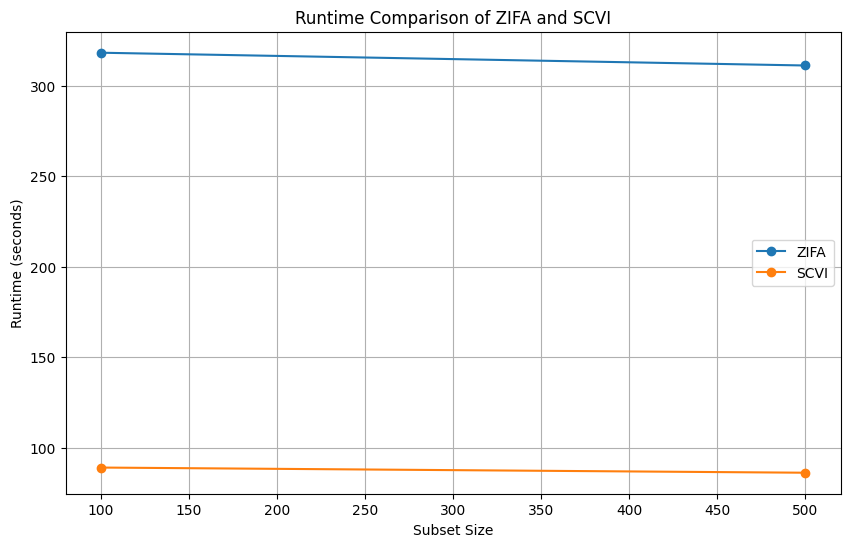

In [56]:
# Plotting the runtime differences
plt.figure(figsize=(10, 6))
plt.plot(sizes, zifa_runtimes, marker='o', label='ZIFA')
plt.plot(sizes, scvi_runtimes, marker='o', label='SCVI')
plt.xlabel('Subset Size')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of ZIFA and SCVI')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
bdata = scvi.data.pbmc_dataset()

INFO     Downloading file at data/gene_info_pbmc.csv                                                               


Downloading...:   0%|          | 0/908.0 [00:00<?, ?it/s]

INFO     Downloading file at data/pbmc_metadata.pickle                                                             


Downloading...:   0%|          | 0/4000.0 [00:00<?, ?it/s]

INFO     Downloading file at data/pbmc8k\filtered_gene_bc_matrices.tar.gz                                          


Downloading...:   0%|          | 0/37558.0 [00:00<?, ?it/s]

INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc8k/filtered_gene_bc_matrices\GRCh38                                   
INFO     Downloading file at data/pbmc4k\filtered_gene_bc_matrices.tar.gz                                          


Downloading...:   0%|          | 0/18424.0 [00:00<?, ?it/s]

INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc4k/filtered_gene_bc_matrices\GRCh38                                   


D:\pythonProject\.venv\Lib\site-packages\scvi\data\_built_in_data\_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


## PBMC Data

In [ ]:
# expression data
data_path = "/home/ubuntu/single-cell-scVI/data/10xPBMCs/"
expression_train = np.load(data_path + "de/data_train.npy")
expression_test = np.load(data_path + "de/data_test.npy")

# qc metrics
r_train = np.load(data_path + "design_train.npy")
r_test = np.load(data_path + "design_test.npy")
qc_train = np.load(data_path + "qc_train.npy")
qc_test = np.load(data_path + "qc_test.npy")

# labels
c_train = np.loadtxt(data_path + "label_train")
c_test = np.loadtxt(data_path + "label_test")

# batch info
b_train = np.loadtxt(data_path + "b_train")
b_test = np.loadtxt(data_path + "b_test")

# corrupted data
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"), np.load(data_path + "imputation/i.npy"),\
        np.load(data_path + "imputation/j.npy"), np.load(data_path + "imputation/ix.npy")
        
#gene info
micro_array_result = pd.read_csv(data_path+"de/gene_info.csv")
gene_names = micro_array_result["ENSG"]
gene_symbols = micro_array_result["GS"]
cd_p_value = micro_array_result["CD_P.Value"]
bdc_p_value = micro_array_result["BDC_P.Value"]
bdc2_p_value = micro_array_result["BDC2_P.Value"]

In [ ]:
# Reset the default graph
tf.compat.v1.reset_default_graph()

# Placeholders
expression = tf.compat.v1.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.compat.v1.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.compat.v1.placeholder(tf.bool, (), name='training_phase')

# Getting priors
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# Model
model = scVIModel(expression=expression, kl_scale=kl_scalar, 
                  optimize_algo=optimizer, phase=training_phase, 
                  library_size_mean=mean, library_size_var=var, n_latent=10)

# Session creation
sess = tf.compat.v1.Session()
print("Running scVI on 3346 genes")
print("scVI will run without batch correction")
print("Will work on mode numeric for incorporating library size")
print("Will work on mode gene for modeling inverse dispersion param")
print("Will apply zero inflation")
print("1 hidden layers at 128 each for a final 10 latent space")

# Start a new graph and fit the training set
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
result = train_model(model, (expression_train, expression_test), sess, 125)

# Save the model
# save_path = saver.save(sess, "/tmp/10xPBMCs_DE_125_ep.ckpt")
# print("Model saved in path: %s" % save_path)
plot_training_info(result)
# saver.restore(sess, "/tmp/10xPBMCs_DE_125_ep.ckpt")

# Evaluation methods
def sample_posterior(model, X, M_z):
    results = {}
    ind = np.arange(X.shape[0])

    # Repeat the data for sampling
    X_m = np.repeat(X, M_z, axis=0)
    ind = np.repeat(ind, M_z, axis=0)
        
    # NN part
    dic_x = {expression: X_m, training_phase: False, kl_scalar: 1.0}
    z_m, l_m = sess.run((model.z, model.library), feed_dict=dic_x)
    dic_z = {model.z: z_m, model.library: l_m, training_phase: False, kl_scalar: 1.0}
    rate, dropout, scale = sess.run((model.px_rate, model.px_dropout, model.px_scale), feed_dict=dic_z)
    dispersion = np.tile(sess.run((tf.exp(model.px_r))), (rate.shape[0], 1))
    
    results["library"] = l_m
    results["mean"] = rate
    results["latent"] = z_m
    results["dispersion"] = dispersion
    results["dropout"] = dropout
    results["sample_rate"] = scale
    results["index"] = ind
    return results

def get_sampling(model, subset_a, subset_b, M_z):
    res_a = sample_posterior(model, expression_train[subset_a], M_z)
    res_b = sample_posterior(model, expression_train[subset_b], M_z)
    return res_a, res_b

def get_statistics(res_a, res_b, M_p=10000, permutation=False):
    samples = np.vstack((res_a["sample_rate"], res_b["sample_rate"]))
    
    list_1 = list(np.arange(res_a["sample_rate"].shape[0]))
    list_2 = list(res_a["sample_rate"].shape[0] + np.arange(res_b["sample_rate"].shape[0]))
    if not permutation:
        u, v = np.random.choice(list_1, size=M_p), np.random.choice(list_2, size=M_p)
    else:
        u, v = np.random.choice(list_1 + list_2, size=M_p), np.random.choice(list_1 + list_2, size=M_p)
    
    first_set = samples[u]
    second_set = samples[v]
    
    res = np.mean(first_set >= second_set, 0)
    res = np.log(res) - np.log(1 - res)
    return res

# Parameters
interest = "BDC"
couple_celltypes = (4, 0)
rank_auc = 800
p_prior = 0.25

# Getting p_values
p_value = micro_array_result[interest + "_adj.P.Val"]
signed_p_value = -np.log10(p_value) * np.sign(micro_array_result[interest + "_logFC"])

# Setting up parameters
A, B, M_z = 100, 100, 200
set_a = np.where(c_train == couple_celltypes[0])[0]
set_b = np.where(c_train == couple_celltypes[1])[0]

# Subsampling cells and computing statistics
subset_a = np.random.choice(set_a, A)
subset_b = np.random.choice(set_b, B)
res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
st = get_statistics(res_a, res_b, M_p=40000)

plt.figure(figsize=(5, 5))
plt.scatter(st, signed_p_value)
plt.axvline(x=3, c="r")
plt.axvline(x=-3, c="r")
plt.axhline(y=np.log10(0.05), c="r")
plt.axhline(y=-np.log10(0.05), c="r")
plt.xlabel("Bayes Factor scVI")
plt.ylabel("Signed log corrected p_value micro-array")
plt.tight_layout()
plt.savefig(interest + "_Bayes_factor_vs_micro_array.pdf", transparency=True)

print(interest)
print("Detected ", np.sum(2 * np.abs(st) >= 6), " genes with scVI")
print("Detected ", np.sum(p_value <= 0.05), " genes with microarray")

## Bipolar Data

In [ ]:
#expression data
data_path = "/home/ubuntu/single-cell-scVI/data/bipolar/"
expression_train = scipy.sparse.load_npz(data_path + "data_train.npz").A
expression_test = scipy.sparse.load_npz(data_path + "data_test.npz").A

# batch info
b_train = np.loadtxt(data_path + "batch_train") - 1
b_test = np.loadtxt(data_path + "batch_test") - 1

#cluster info
c_train = np.loadtxt(data_path + "c_train")
c_test = np.loadtxt(data_path + "c_test")

# imputation dataset
X_zero, i, j, ix = \
        scipy.sparse.load_npz(data_path + "imputation/X_zero.npz").A,\
        np.load(data_path + "imputation/i.npy"), \
        np.load(data_path + "imputation/j.npy"), \
        np.load(data_path + "imputation/ix.npy")

In [ ]:
# Reset the default graph
tf.compat.v1.reset_default_graph()

# Placeholders
expression = tf.compat.v1.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
batch_ind = tf.compat.v1.placeholder(tf.int32, [None], name='b_ind')
kl_scalar = tf.compat.v1.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.compat.v1.placeholder(tf.bool, (), name='training_phase')
mmd_scalar = tf.compat.v1.placeholder(tf.float32, [], name='l')

# Getting priors
log_library_size = np.log(np.sum(expression_train, axis=1))
l_mean, l_var = np.mean(log_library_size), np.var(log_library_size)

# Model
model = scVIModel(expression=expression, batch_ind=batch_ind, num_batches=2, kl_scale=kl_scalar, 
                  apply_mmd=False, phase=training_phase, mmd_scale=mmd_scalar, 
                  optimize_algo=optimizer, library_size_mean=l_mean, library_size_var=l_var, 
                  dispersion="gene")

# Session creation
sess = tf.compat.v1.Session()
print("Running scVI on 13166 genes")
print("Got 2 batches in the data")
print("Will not apply a MMD penalty")
print("Will work on mode numeric for incorporating library size")
print("Will work on mode gene for modeling inverse dispersion param")
print("Will apply zero inflation")
print("1 hidden layers at 128 each for a final 10 latent space")

# Start a new graph and fit the training set
sess.run(tf.compat.v1.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 120, batch=(b_train, b_test))
plot_training_info(result)

# Evaluation methods
latent = eval_latent(model, expression_train, sess, batch=b_train)
print(cluster_scores(latent, len(np.unique(c_train)), c_train))
print(entropy_batch_mixing(latent, b_train))
print(silhouette_score(latent, b_train))

tsne = show_tSNE(latent, c_train, cmap=plt.get_cmap("tab20", 15), return_tSNE=True)
plt.show()
show_tSNE(tsne, b_train, cmap=plt.get_cmap("brg", 2))
plt.show()

# Imputation
sess.run(tf.compat.v1.global_variables_initializer())
res = train_model(model, (X_zero, expression_test), sess, 120, batch=(b_train, b_test))
eval_imputed_data(model, (X_zero, i, j, ix), expression_train, sess, batch=b_train)